In [1]:
import random # rng generator in python
import time # can be used to get current time
import torch # Pytorch is one of the most used machine learning frameworks in academia
import torch.nn as nn # nn contains the neural network functions of pytorch
import torchvision # For Image Processing
from torchvision import datasets, models, transforms
from torch.utils.data import random_split, DataLoader # Creating datasets
import os # load data
import numpy as np # work with matrices
from PIL import Image # Pillow is a commonly used Image Processing Library 
import matplotlib.pyplot as plt #for visualization
import pandas as pd # for creating dataframes and later saving the .csv
!pip install torchsampler
from torchsampler import ImbalancedDatasetSampler
import shutil
import cv2

# makes this exercise determinsitic
torch.manual_seed(3407)
random.seed(3407)
np.random.seed(3407)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark = False

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Hyperparameter zum tunen

train_percentage = 0.85                   # Aufteilung in Trainings- und Validierungsdaten
batchsize = 32                            # Anzahl Bilder pro batch in Stochastic Gradient Descent/AdamW
use_imbalanced_dataset_sampler = False    # Verwenden des ImbalancedDatasetSampler
learning_rate_1 = 5e-5                    # Zwei Lernraten (zwei verschiedene weil... siehe unten xD)
learning_rate_2 = 1e-5
step_size = 1                             # Step-Size für Learning Rate Decay
gamma = 0.85                              # Learning Rate Decay Faktor
dropout_prob = 0.3                        # Dropout Wahrscheinlichkeit für die Dropout Layer im Klassifizierer
alternative = 3                           # 1: train whole model, 2: train only classifier, 3: first whole model, then finetune classifier
early_stopping_limit = 12                 # Number of epochs without decreasing loss, after which early stopping stops the training

In [3]:
root = '/content/drive/'
mydrive = root + "MyDrive/"

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount(root)

# Unzip the uploaded files (if not already unzipped)
#!unzip drive/MyDrive/train_val.zip -d drive/MyDrive/
#!unzip drive/MyDrive/test.zip -d drive/MyDrive/

Mounted at /content/drive/


Random Train/Val data:


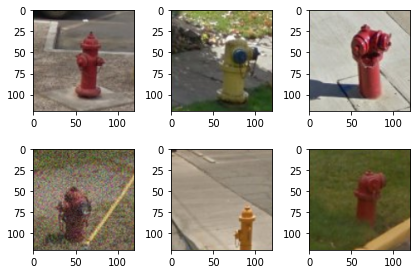

Random Test data:


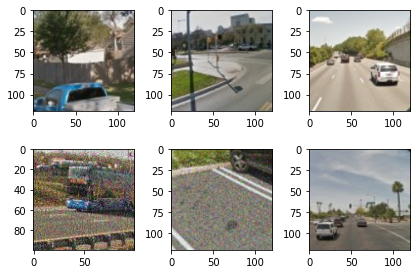

In [4]:
# Inspect random data

print(f"Random Train/Val data:")

fig = plt.figure()
train_val_root = mydrive + "train_val_data/Hydrant/"
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(Image.open(train_val_root + sorted(os.listdir(train_val_root))[i]))

plt.show()

print(f"Random Test data:")

fig = plt.figure()
test_root = mydrive + "test_data/test/"
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(Image.open(test_root + sorted(os.listdir(test_root))[i]))

plt.show()

In [5]:
# Transformations (separated for each train, val and test)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],  # mean of ImageNet
                                 std=[0.229, 0.224, 0.225])   # std of ImageNet
data_transforms = {
    'train': 
        transforms.Compose([
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomRotation(10),       # Till here
            transforms.CenterCrop(120), # crop every image to size 224x224 -> changed to 120
            transforms.ToTensor(),      # saves image as tensor (automatically divides by 255)
            normalize,
            transforms.RandomGrayscale(0.01)
        ]),
    'val':
        transforms.Compose([
            transforms.CenterCrop(120), # should be the same resolution as the test_transform
            transforms.ToTensor(),
            normalize,
        ]),
    'test':
        transforms.Compose([
            transforms.CenterCrop(120), # should be the same resolution as the test_transform
            transforms.ToTensor(),
            normalize,
        ])}   

In [6]:
# Funktion zur Aufteilung der Daten in Train und Val auf Datei/Verzeichnis-Ebene

# Hilfsfunktion
def get_length_of_data_folder(path):
    length = 0
    for class_name in os.listdir(path):
        class_folder = path + "/" + class_name
        length += len(os.listdir(class_folder))
    return length

# Hilfsfunktion
def remove_folder_content(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))


def split_folder(root_folder, train_percentage):
    classes = os.listdir(root_folder)
    # Make new directories for train and val
    if not os.path.exists("/content/drive/MyDrive/train_data"):
        !mkdir /content/drive/MyDrive/train_data
        for class_name in classes:
            os.mkdir("/content/drive/MyDrive/train_data/" + class_name)
    if not os.path.exists("/content/drive/MyDrive/val_data"):
        !mkdir /content/drive/MyDrive/val_data
        for class_name in classes:
            os.mkdir("/content/drive/MyDrive/val_data/" + class_name)
    # Get length of the data
    train_val_length = get_length_of_data_folder(root_folder)
    no_train_images = int(train_val_length * train_percentage)
    no_valid_images = train_val_length - no_train_images
    # only execute this function, if a new split is wanted
    if (get_length_of_data_folder("/content/drive/MyDrive/train_data")==no_train_images) and (get_length_of_data_folder("/content/drive/MyDrive/val_data")==no_valid_images):
        print("train_data and val_data already exist with the specified split.")
        return
    else:
        print("Splitting the root folder in shuffled train_data and val_data folders... ")
    # Remove old images (from previous split)
    for class_name in classes:
        class_folder_train = "/content/drive/MyDrive/train_data/" + class_name
        remove_folder_content(class_folder_train)
        class_folder_val = "/content/drive/MyDrive/val_data/" + class_name
        remove_folder_content(class_folder_val)
    # Get indices of all images
    indices = list(range(train_val_length))
    # Remove the first two images of each class and copy them by hand
    # (to make sure that each folder in train_data and val_data has at least one image)
    counter = 0
    for class_name in classes:
            indices.remove(counter)
            indices.remove(counter+1)
            class_folder = root_folder + "/" + class_name
            src1 = class_folder + "/" + os.listdir(class_folder)[0]
            dst1 = "/content/drive/MyDrive/train_data/" + class_name + "/" + os.listdir(class_folder)[0]
            shutil.copyfile(src1, dst1)
            src2 = class_folder + "/" + os.listdir(class_folder)[1]
            dst2 = "/content/drive/MyDrive/val_data/" + class_name + "/" + os.listdir(class_folder)[1]
            shutil.copyfile(src2, dst2)
            counter += len(os.listdir(class_folder))
    # Shuffle the remaining indices for a random split
    np.random.shuffle(indices)
    # Fill new directories according to the shuffled indices
    for i, idx in enumerate(indices):
        counter = 0
        old_counter = 0
        for class_name in classes:
            class_folder = root_folder + "/" + class_name
            counter += len(os.listdir(class_folder))
            if idx>=old_counter and idx<counter:
                src = class_folder + "/" + os.listdir(class_folder)[idx-old_counter]
                if i < no_train_images-len(classes):
                    dst = "/content/drive/MyDrive/train_data/" + class_name + "/" + os.listdir(class_folder)[idx-old_counter]
                else:
                    dst = "/content/drive/MyDrive/val_data/" + class_name + "/" + os.listdir(class_folder)[idx-old_counter]
                shutil.copyfile(src, dst)
                break
            old_counter = counter    

In [7]:
# Aufteilung der Daten in Train und Val auf Datei/Verzeichnis-Ebene
split_folder("drive/MyDrive/train_val_data", train_percentage)

Splitting the root folder in shuffled train_data and val_data folders... 


In [8]:
## Erstellung der Datensets

# Getrennte Train- und Val- datasets
train_dataset = datasets.ImageFolder(root=mydrive + "train_data/", transform=data_transforms['train'])
train_length = len(train_dataset)
print(f"The train dataset contains {train_length} labeled images")
val_dataset = datasets.ImageFolder(root=mydrive + "val_data/", transform=data_transforms['val'])
val_length = len(val_dataset)
print(f"The val dataset contains {val_length} labeled images")

# Test dataset
test_dataset = datasets.ImageFolder(root=mydrive + "test_data/", transform=data_transforms['test'])
print(f"The test dataset contains {len(test_dataset)} unlabeled images") # should be 8730


The train dataset contains 2550 labeled images
The val dataset contains 450 labeled images
The test dataset contains 8730 unlabeled images


An element of a train_val_dataset contains 2 fields. (should be 2). The first field is an image, the second value is its corresponding label 

An element of a train_dataset contains 2 fields. (should be 2). The first field is an image, the second value is its corresponding label 

tensor of first image tensor([[[-0.9877, -0.9705, -0.9877,  ..., -1.2274, -0.8507,  0.1597],
         [-0.9877, -0.9534, -0.9877,  ..., -1.4158, -0.9192,  0.2624],
         [-0.6109, -0.6452, -0.7308,  ..., -1.1418, -0.7308,  0.1768],
         ...,
         [-0.4911, -0.4911, -0.4739,  ..., -1.0390, -1.0048, -0.9534],
         [-0.5253, -0.5424, -0.5253,  ..., -1.0048, -1.0048, -0.9705],
         [-0.5767, -0.5938, -0.5938,  ..., -0.9705, -0.9877, -0.9705]],

        [[-1.0203, -1.0203, -1.0378,  ..., -1.1078, -0.8102,  0.0826],
         [-1.0378, -1.0028, -1.0378,  ..., -1.3004, -0.8452,  0.3277],
         [-0.6352, -0.6702, -0.7752,  ..., -1.0203, -0.6001,  0.3277],
         ...,
         [-0.3725, -0.3550,

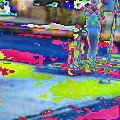

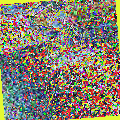

We have the following classes ['Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney', 'Crosswalk', 'Hydrant', 'Motorcycle', 'Other', 'Palm', 'Stair', 'Traffic Light']
Each class gets an index value {'Bicycle': 0, 'Bridge': 1, 'Bus': 2, 'Car': 3, 'Chimney': 4, 'Crosswalk': 5, 'Hydrant': 6, 'Motorcycle': 7, 'Other': 8, 'Palm': 9, 'Stair': 10, 'Traffic Light': 11}
For the first image we have index 0
For the second image we have index 0


In [9]:
## Test the Datasets and look at the first element
first_elem = val_dataset.__getitem__(0)
second_elem = train_dataset.__getitem__(0)
print(f"An element of a train_val_dataset contains {len(first_elem)} fields. (should be 2). The first field is an image, the second value is its corresponding label \n")
print(f"An element of a train_dataset contains {len(second_elem)} fields. (should be 2). The first field is an image, the second value is its corresponding label \n")

# the first index should be a tensor representation of an image
print("tensor of first image", first_elem[0], "\n")
print("image should be of shape 3,size,size: ", first_elem[0].shape)
print("tensor of second image", second_elem[0], "\n")
print("image should be of shape 3,size,size: ", second_elem[0].shape)

# convert tensor back to a PIL image and visualize it with display()
display(transforms.ToPILImage()(first_elem[0]))        
display(transforms.ToPILImage()(second_elem[0]))       
# Each folder is a class
classes = train_dataset.classes
print("We have the following classes", classes)

# Each classname is assigned an index
class_names = train_dataset.class_to_idx
print("Each class gets an index value", class_names)

# the second index is the numerical value of our label taken from the folder name
print(f"For the first image we have index {first_elem[1]}")
print(f"For the second image we have index {second_elem[1]}")

In [10]:
## Create Dataloader for Train and Val Data

dataloaders = {                   
    'train':
        DataLoader(
            dataset=train_dataset,
            batch_size=batchsize,
            sampler=ImbalancedDatasetSampler(train_dataset) if use_imbalanced_dataset_sampler else None,          # Rebalancing class distributions (exclusively used with shuffle=True)
            shuffle=False if use_imbalanced_dataset_sampler else True,
            num_workers=2),             # Num_workers = Size of CPU kernels, colab suggested in a warning message 2 for the current system (FT)
    'validation':
        DataLoader(
            dataset=val_dataset,
            batch_size=batchsize,              
            shuffle=False,
            num_workers=2) }

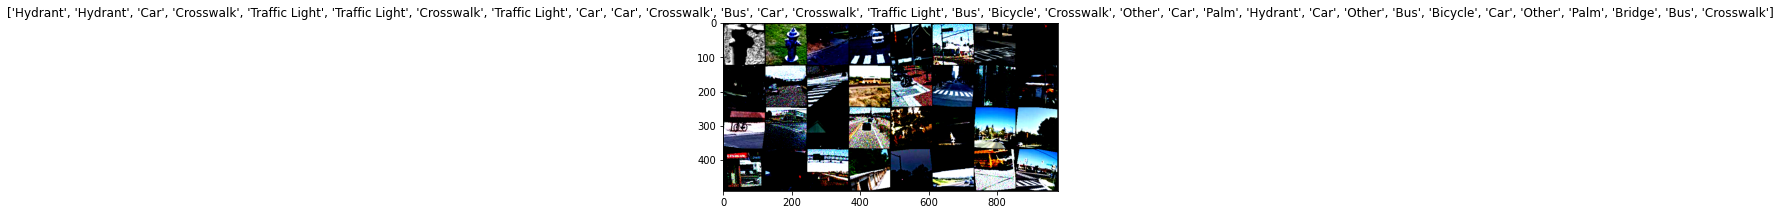

In [11]:
# Test and visualize the train loader
def vis_batch(loader):
    def show(inp, label):
        fig = plt.gcf()
        plt.imshow(inp.permute(1,2,0))
        plt.title(label)
    
    for batch_inputs, labels in loader:
        grid = torchvision.utils.make_grid(batch_inputs)
        show(grid, label=[classes[int(labels[x])] for x in range(len(labels))])
        break
vis_batch(dataloaders['train'])

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("RUNNING ON ", device) # should be cuda

RUNNING ON  cuda:0


In [13]:
# Load Swin Transformer v2

def get_model_and_optimizer(pretrained=True, only_train_classifier=True, lr=2e-4, step_size=1, gamma=0.9, dropout=0.3):
    # load model architecture from pytorch and also return optimizer
    # if pretrained == true, then also load imagenet weights. otherwise use kaiming initialization

    if pretrained:
        # "DEFAULT" are weights trained on ImageNet
        model = models.swin_v2_s(weights='DEFAULT').to(device) # put it to GPU

        # We don't want to change the learned ImageNet weights. Disable gradient calculation for CNN
        if only_train_classifier:
            for param in model.parameters():
                param.requires_grad = False
    else:
        # None --> Kaiming/He initialization
        model = models.swin_v2_s(weights=None).to(device)

    # create a new classifier
    n_inputs = model.head.in_features
    model.head = nn.Sequential(
        nn.Linear(n_inputs, 512),
        nn.LeakyReLU(),
        nn.Dropout(dropout),
        nn.Linear(512, len(classes))
    )
    # use AdamW and give it the trainable parameters
    if pretrained:
        if only_train_classifier:
            # only calculate gradients of the classifier
            optimizer = torch.optim.AdamW(model.head.parameters(), lr=lr)
        else:
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    else:
        # calculate gradients for full network
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    return model.to(device), optimizer, exp_lr_scheduler

In [14]:
# Define Training and Validation

def validation(model):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad(): # don't calculate gradients in validation
        running_loss = 0.0
        running_corrects = 0 # used for accuracy calculation
        for inputs, labels in dataloaders['validation']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted_class = torch.max(outputs, 1) # _ = the highest prediction, --> predicted_class, which index hat the highest predicition 
            running_corrects += torch.sum(predicted_class == labels)

        validation_loss = running_loss / len(val_dataset)
        validation_acc = running_corrects / len(val_dataset) * 100
        print(f"Validation loss is: {validation_loss:.4f}, Validation accuracy is: {validation_acc:.2f}%")
        print('-' * 20)
        return validation_loss, validation_acc

def train_model(model, optimizer, scheduler, num_epochs=70, early_stopping=True, early_stopping_limit=12, previous_validation_loss = np.inf, previous_validation_acc = 0):
    start = time.time()
    criterion = nn.CrossEntropyLoss()
    early_stopping_counter = 0
    best_validation_loss = previous_validation_loss
    best_validation_acc = previous_validation_acc
    # For plotting
    train_loss_history = []
    valid_loss_history = []
    if best_validation_loss != np.inf:
        valid_loss_history.append(best_validation_loss)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in dataloaders['train']:
            model.train()

            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted_class = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted_class == labels)
            
        scheduler.step()
        epoch_loss = running_loss / len(train_dataset)
        train_loss_history.append(epoch_loss)
        epoch_acc = running_corrects / len(train_dataset) * 100
        
        print(f"training epoch loss is = {epoch_loss:.4f}, Training accuracy is {epoch_acc:.2f}%")

        validation_loss, validation_acc = validation(model)
        valid_loss_history.append(validation_loss)

        # Early-Stopping: if validation loss doesn't decrease for 12 (early_stopping_limit) consecutive epochs, stop training and use checkpoint
        if early_stopping:
            # keep track of best validation loss so far
            if validation_loss < best_validation_loss:
                best_validation_loss = validation_loss
                best_validation_acc = validation_acc
                early_stopping_counter = 0
                torch.save(model.state_dict(),"checkpoint.pt")              # saving best weights so far
            else:
                early_stopping_counter += 1
                if early_stopping_counter == early_stopping_limit:
                    print("*" * 70)
                    # Print loss curves
                    fig = plt.figure()
                    plt.plot(range(1,1+len(train_loss_history)),train_loss_history, label="Training Loss")
                    if len(train_loss_history) == len(valid_loss_history):
                        plt.plot(range(1,1+len(valid_loss_history)),valid_loss_history, label="Validation Loss")
                    else:     
                        plt.plot(range(0,len(valid_loss_history)),valid_loss_history, label="Validation Loss")
                    plt.axvline(epoch+1-early_stopping_limit, label="Early Stopping", color='r')
                    plt.legend()
                    plt.show()
                    print(f"Early-Stopping activated: Using weights from epoch {epoch+1-early_stopping_limit}")
                    print(f"Result: Validation Loss =  {best_validation_loss:.4f}, Validation Accuracy = {best_validation_acc:.2f}")
                    model.load_state_dict(torch.load('checkpoint.pt'))      # loading best weights
                    break
    
    print(f"This took {round(time.time() - start)} seconds")
    return model, best_validation_loss, best_validation_acc

**********************************************************************
First step: Training whole model
--------------------------------------------------


Downloading: "https://download.pytorch.org/models/swin_v2_s-637d8ceb.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_s-637d8ceb.pth


  0%|          | 0.00/191M [00:00<?, ?B/s]

Epoch 1/70
----------
training epoch loss is = 1.6577, Training accuracy is 47.76%
Validation loss is: 0.8072, Validation accuracy is: 75.11%
--------------------
Epoch 2/70
----------
training epoch loss is = 0.6688, Training accuracy is 79.18%
Validation loss is: 0.5277, Validation accuracy is: 82.67%
--------------------
Epoch 3/70
----------
training epoch loss is = 0.4445, Training accuracy is 84.90%
Validation loss is: 0.5154, Validation accuracy is: 83.78%
--------------------
Epoch 4/70
----------
training epoch loss is = 0.3458, Training accuracy is 88.86%
Validation loss is: 0.5330, Validation accuracy is: 84.67%
--------------------
Epoch 5/70
----------
training epoch loss is = 0.2759, Training accuracy is 90.90%
Validation loss is: 0.5065, Validation accuracy is: 85.78%
--------------------
Epoch 6/70
----------
training epoch loss is = 0.2312, Training accuracy is 92.55%
Validation loss is: 0.5128, Validation accuracy is: 86.22%
--------------------
Epoch 7/70
----------


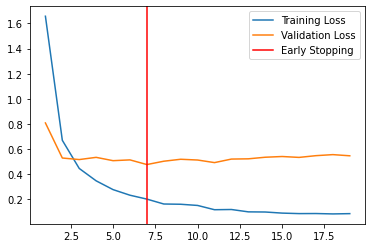

Early-Stopping activated: Using weights from epoch 7
Result: Validation Loss =  0.4756, Validation Accuracy = 86.67
This took 525 seconds
**********************************************************************
Second step: Training only classifier
--------------------------------------------------
Epoch 1/70
----------
training epoch loss is = 0.1717, Training accuracy is 94.51%
Validation loss is: 0.4875, Validation accuracy is: 86.67%
--------------------
Epoch 2/70
----------
training epoch loss is = 0.1590, Training accuracy is 95.29%
Validation loss is: 0.4914, Validation accuracy is: 87.11%
--------------------
Epoch 3/70
----------
training epoch loss is = 0.1600, Training accuracy is 94.98%
Validation loss is: 0.4970, Validation accuracy is: 87.33%
--------------------
Epoch 4/70
----------
training epoch loss is = 0.1667, Training accuracy is 94.35%
Validation loss is: 0.4997, Validation accuracy is: 87.56%
--------------------
Epoch 5/70
----------
training epoch loss is = 0.1

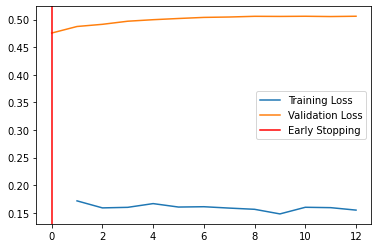

Early-Stopping activated: Using weights from epoch 0
Result: Validation Loss =  0.4756, Validation Accuracy = 86.67
This took 121 seconds


In [15]:
## Get model and start training!
# Alternative 1: train whole model
# Alternative 2: train only classifier
# Alternative 3: train first whole model, then finetune classifier

if alternative == 1:
    print("*"*70)
    print("Training whole model")
    print("-"*50)
    model, optimizer, scheduler = get_model_and_optimizer(pretrained=True, only_train_classifier=False, lr=learning_rate_1, step_size=step_size, gamma=gamma, dropout=dropout_prob)
    model, validation_loss, validation_acc = train_model(model, optimizer, scheduler, num_epochs=70, early_stopping_limit=early_stopping_limit)
elif alternative == 2:
    print("*"*70)
    print("Training only classifier")
    print("-"*50)
    model, optimizer, scheduler = get_model_and_optimizer(pretrained=True, only_train_classifier=True, lr=learning_rate_1, step_size=step_size, gamma=gamma, dropout=dropout_prob)
    model, validation_loss, validation_acc = train_model(model, optimizer, scheduler, num_epochs=70, early_stopping_limit=early_stopping_limit)
elif alternative == 3:
    print("*"*70)
    print("First step: Training whole model")
    print("-"*50)
    temp_model, optimizer, scheduler = get_model_and_optimizer(pretrained=True, only_train_classifier=False, lr=learning_rate_1, step_size=step_size, gamma=gamma, dropout=dropout_prob)
    temp_model, validation_loss, validation_acc = train_model(temp_model, optimizer, scheduler, num_epochs=70, early_stopping_limit=early_stopping_limit)
    torch.save(temp_model.state_dict(),"checkpoint.pt")
    print("*"*70)
    print("Second step: Training only classifier")
    print("-"*50)
    model, optimizer, scheduler = get_model_and_optimizer(pretrained=True, only_train_classifier=True, lr=learning_rate_2, step_size=step_size, gamma=gamma, dropout=dropout_prob)
    model.load_state_dict(torch.load("checkpoint.pt"))  # load weights from temp_model
    model, validation_loss, validation_acc = train_model(model, optimizer, scheduler, num_epochs=70, previous_validation_loss=validation_loss, previous_validation_acc=validation_acc, early_stopping_limit=early_stopping_limit)
else:
    print("Choose a valid number for alternative: 1, 2 or 3")

Predicted class: Bus
Labelscore: 0.9980394244194031


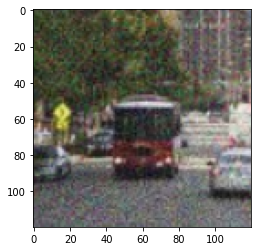

In [16]:
# Test prediction for a single image

# Load Image
test_root =  mydrive + "test_data/test/"
img = Image.open(test_root + "03130.png").convert('RGB')
imgplot = plt.imshow(img)

img = data_transforms['test'](img)    
img = torch.unsqueeze(img, 0)

# switch off autograd
with torch.no_grad():

  model.eval()
  #prediction = F.softmax(pretr_model(img), dim = 1)

  # send the input to the device and make predictions on it
  img = img.to(device)
  #pred = model(img)
  output = model(img)
  #_, predicted = torch.max(output.data,1)
  _,predicted = torch.max(output,1)

  print(f'Predicted class: {classes[predicted.item()]}')
 
  probs = torch.nn.functional.softmax(output, dim=1)
  conf, _ = torch.max(probs, 1)

  print(f'Labelscore: {conf[0]}')

In [17]:
# Save the model to a file on Google Drive
model_name = "swin_transformer_s."
torch.save(model.state_dict(), mydrive + model_name + f"{validation_acc:.2f}" '.pt')

In [18]:
# Speichere die Parameter in Drive zur Dokumentation
with open(f"/content/drive/MyDrive/Hyperparameter.{validation_acc:.2f}.txt", 'w') as f:
    parameter = []
    parameter += f"Dokumentation der Hyperparameter zum Model {model_name}\n\n"
    parameter += f"Erreichte Genauigkeit auf den Validierungsdaten: {validation_acc:.2f}%\n\n"
    parameter += f"train_percentage = {train_percentage}\n"
    parameter += f"batchsize = {batchsize}\n"
    parameter += f"use_imbalanced_dataset_sampler = {use_imbalanced_dataset_sampler}\n"
    parameter += f"learning_rate_1 = {learning_rate_1}\n"
    parameter += f"learning_rate_2 = {learning_rate_2}\n"
    parameter += f"step_size = {step_size}\n"
    parameter += f"gamma = {gamma}\n"
    parameter += f"dropout_prob = {dropout_prob}\n"
    parameter += f"alternative = {alternative}\n"
    parameter += f"early_stopping_limit = {early_stopping_limit}\n"
    parameter += f"\n\nData Augmentations/Transformations:\n\n"
    parameter += f"train_dataset:\n"
    parameter += str(data_transforms["train"].__repr__)
    parameter += f"\n\nval_dataset:\n"
    parameter += str(data_transforms["val"].__repr__)
    parameter += f"\n\ntest_dataset:\n"
    parameter += str(data_transforms["test"].__repr__)
    f.writelines(parameter)

In [19]:
# Predict full testdata for final Prediction csv ... 

def create_result_file(model, test_dataset, classes): # DO NOT CHANGE THIS METHOD
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    keys = ["ImageName", *classes] 

    prediction_dict = {key: [] for key in keys}
    names = test_dataset.imgs
    model.to(device)
    model.eval() # set model to evaluation mode. 
    for i in range(len(test_dataset)):
        if (i+1)%50==0:
            print("Progress: " + str(i+1) + "/" + str(len(test_dataset)))
        input = test_dataset.__getitem__(i)
        input = input[0].to(device).unsqueeze(0) # take image tensor and add batch dimension
        with torch.no_grad(): # don't calculate gradients
            outputs = model(input).cpu().squeeze().numpy() # get prediction for input image
            prediction_dict["ImageName"].append(os.path.basename(names[i][0])) # save image name
            for class_idx, class_name in enumerate(classes): # save prediction for each class 
                prediction_dict[class_name].append(outputs[class_idx])
        
    df = pd.DataFrame.from_dict(prediction_dict) # convert list into pandas dataframe
    df.to_csv(f"result.{validation_acc:.2f}.csv", index=False) # save dataframe as .csv
    print("Finally done!")

!rm result.*.csv
create_result_file(model, test_dataset, classes)
!cp result.*.csv /content/drive/MyDrive

rm: cannot remove 'result.*.csv': No such file or directory
Progress: 50/8730
Progress: 100/8730
Progress: 150/8730
Progress: 200/8730
Progress: 250/8730
Progress: 300/8730
Progress: 350/8730
Progress: 400/8730
Progress: 450/8730
Progress: 500/8730
Progress: 550/8730
Progress: 600/8730
Progress: 650/8730
Progress: 700/8730
Progress: 750/8730
Progress: 800/8730
Progress: 850/8730
Progress: 900/8730
Progress: 950/8730
Progress: 1000/8730
Progress: 1050/8730
Progress: 1100/8730
Progress: 1150/8730
Progress: 1200/8730
Progress: 1250/8730
Progress: 1300/8730
Progress: 1350/8730
Progress: 1400/8730
Progress: 1450/8730
Progress: 1500/8730
Progress: 1550/8730
Progress: 1600/8730
Progress: 1650/8730
Progress: 1700/8730
Progress: 1750/8730
Progress: 1800/8730
Progress: 1850/8730
Progress: 1900/8730
Progress: 1950/8730
Progress: 2000/8730
Progress: 2050/8730
Progress: 2100/8730
Progress: 2150/8730
Progress: 2200/8730
Progress: 2250/8730
Progress: 2300/8730
Progress: 2350/8730
Progress: 2400/8730
